In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error

In [2]:
import sys
sys.path.append('/Users/hauptjoh/projects/research/treatment-learn')

from treatlearn.policy import bayesian_targeting_policy
from treatlearn.evaluation import transformed_outcome_loss, expected_policy_profit

## Load Data

Confirm the path to the actual data and the path where the model results are saved.

In [3]:
DATA_PATH = "../data/fashionB_clean_nonlinear.csv"
RESULT_PATH = "20201220-fullRun"

In [4]:
# Load data
X = pd.read_csv(DATA_PATH)

c = X.pop('converted').to_numpy()
g = X.pop('TREATMENT').to_numpy()
y = X.pop('checkoutAmount').to_numpy()
tau_conversion = X.pop('TREATMENT_EFFECT_CONVERSION')
tau_basket = X.pop('TREATMENT_EFFECT_BASKET')
tau_response = X.pop('TREATMENT_EFFECT_RESPONSE')

In [5]:
# Load model predictions
predictions = np.load(f"../results/{RESULT_PATH}/treatment_model_predictions.npy", allow_pickle=True)
predictions_train = [fold["train"] for fold in predictions]
predictions_test = [fold["test"] for fold in predictions]

In [6]:
# for _pred in [predictions_train, predictions_test]:
#     for _x in _pred:
#         _x['treatment_spending']['xbcf_outcome_gbt'] = _x['treatment_spending']['xbcf']
#         del _x['treatment_spending']['xbcf']

## Conversion Predictions C(T=1)

In [7]:
# ##### Comparison on AUC

def calc_classification_error(prediction_dict, y_true, g):
    """
    Calculate the prediction error of the model predictions
    prediction_dict : dict
        Dictionary with the model predictions in the form model_name: array of predictions
    y_true : 1D array-like
        Observed outcomes
    g : 1D array-like
        Binary group indicator
    prob_treatment : array-like or int
        The group propensity for each observation. If None or int, the constant probability
        to be in binary treatment group 1.
    tau_true : 1D array-like
        Array of the true treatment effect. The true treatment effect
        is only known in simulations
    """
    output = {}
    
    for model_name, pred in prediction_dict.items():
        output[model_name] = {}
        output[model_name]["ROC-AUC"] = roc_auc_score(y_true=y_true[g], y_score=pred[g]) 
        output[model_name]["brier"] = mean_squared_error(y_pred=pred[g], y_true=y_true[g])

    return output

In [8]:
eval_conversion = [calc_classification_error(outcome_dict["conversion"], y_true=c[outcome_dict["idx"]], g=np.nonzero(g[outcome_dict["idx"]]))
             for outcome_dict in predictions_test]

In [9]:
eval_conversion = pd.concat([pd.DataFrame(x) for x in eval_conversion], axis=0, keys=range(len(eval_conversion)))
eval_conversion.index.rename(["fold","metric"], inplace=True)

In [10]:
eval_conversion = eval_conversion.groupby("metric").mean().T

In [11]:
eval_conversion.index = pd.MultiIndex.from_tuples(eval_conversion.index.str.split("_", expand=True).tolist())
eval_conversion = eval_conversion.rename(mapper={"ROC-AUC": "ROC-AUC", "brier": "Brier Score"}, axis=1)

In [12]:
eval_conversion

metric                           ROC-AUC  Brier Score
single-model    outcome linear  0.654213     0.101727
                        gbt     0.669268     0.100719
                hurdle  gbt     0.669039     0.100560
two-model       hurdle  linear  0.654232     0.101720
                        gbt     0.663386     0.101037
Conversion-Rate                 0.500000     0.105053

In [13]:
eval_conversion.to_latex(buf="../results/conversion_prediction_quality.tex", float_format="%.3f")

## Treatment Effect Precision

In [14]:
# ##### Comparison on transformed outcome loss

def calc_prediction_error(prediction_dict, y_true, g, prob_treatment=None, tau_true=None):
    """
    Calculate the prediction error of the model predictions
    prediction_dict : dict
        Dictionary with the model predictions in the form model_name: array of predictions
    y_true : 1D array-like
        Observed outcomes
    g : 1D array-like
        Binary group indicator
    prob_treatment : array-like or int
        The group propensity for each observation. If None or int, the constant probability
        to be in binary treatment group 1.
    tau_true : 1D array-like
        Array of the true treatment effect. The true treatment effect
        is only known in simulations
    """
    output = {}
    
    if prob_treatment is None:
        prob_treatment = g.mean()
    
    for model_name, pred in prediction_dict.items():
        output[model_name] = {}
        print(model_name, pred.min().round(0), pred.mean().round(0), pred.max().round(0))
        pred = pred.clip(-200,200)
        output[model_name]["transformed_outcome_loss"] = transformed_outcome_loss(tau_pred=pred, y_true=y_true, g=g, 
                                                                                  prob_treatment=prob_treatment)
        if tau_true is not None:
            output[model_name]["root_mean_squared_error"] = np.sqrt(mean_squared_error(y_pred=pred, y_true=tau_true))
            output[model_name]["mean_absolute_error"] = mean_absolute_error(y_pred=pred, y_true=tau_true)

    return output

In [15]:
eval_test = [calc_prediction_error(outcome_dict["treatment_spending"], 
                                   y[outcome_dict["idx"]], g[outcome_dict["idx"]], tau_true=tau_response[outcome_dict["idx"]]) 
             for outcome_dict in predictions_test]

single-model_outcome_gbt -2.0 4.0 22.0
single-model_hurdle_gbt 0.0 4.0 29.0
two-model_outcome_linear -1555.0 5.0 49.0
two-model_outcome_gbt -10.0 5.0 38.0
two-model_hurdle_linear -40.0 5.0 46.0
two-model_hurdle_gbt -14.0 5.0 34.0
dr_outcome_linear -1528.0 5.0 53.0
dr_outcome_gbt -11.0 5.0 41.0
xbcf_outcome_xbcf -3.0 5.0 19.0
oracle__ -3.0 5.0 50.0
ATE__ 5.0 5.0 5.0
single-model_outcome_gbt -5.0 4.0 36.0
single-model_hurdle_gbt -6.0 4.0 32.0
two-model_outcome_linear -414.0 5.0 79.0
two-model_outcome_gbt -10.0 5.0 31.0
two-model_hurdle_linear -21.0 5.0 191.0
two-model_hurdle_gbt -17.0 5.0 56.0
dr_outcome_linear -418.0 5.0 88.0
dr_outcome_gbt -381.0 5.0 327.0
xbcf_outcome_xbcf -3.0 5.0 22.0
oracle__ -4.0 5.0 40.0
ATE__ 5.0 5.0 5.0
single-model_outcome_gbt -5.0 4.0 34.0
single-model_hurdle_gbt -4.0 4.0 35.0
two-model_outcome_linear -227.0 5.0 97.0
two-model_outcome_gbt -8.0 5.0 37.0
two-model_hurdle_linear -58.0 5.0 103.0
two-model_hurdle_gbt -10.0 5.0 29.0
dr_outcome_linear -237.0 5.0 111

In [16]:
eval_test_dataframe = pd.concat([pd.DataFrame(x) for x in eval_test], axis=0, keys=range(len(eval_test)))
eval_test_dataframe.index.rename(["fold","metric"], inplace=True)

In [17]:
eval_precision = eval_test_dataframe.groupby("metric").mean().T
#print(eval_test_dataframe.groupby("metric").std().T)

In [18]:
eval_precision.index = pd.MultiIndex.from_tuples(eval_precision.index.str.split("_", expand=True).tolist())
eval_precision = eval_precision.rename(mapper={"transformed_outcome_loss": "TOL", "root_mean_squared_error": "RMSE", "mean_absolute_error": "MAE"}, axis=1)

In [19]:
eval_precision.round(2)

metric                           TOL  RMSE   MAE
single-model outcome gbt     4180.37  3.11  2.32
             hurdle  gbt     4180.13  3.08  2.29
two-model    outcome linear  4183.06  3.44  2.35
                     gbt     4181.10  3.39  2.44
             hurdle  linear  4186.06  3.83  2.53
                     gbt     4183.05  3.40  2.45
dr           outcome linear  4183.31  3.48  2.35
                     gbt     4181.76  3.26  2.23
xbcf         outcome xbcf    4177.79  2.71  1.92
oracle                       4164.46  0.00  0.00
ATE                          4186.27  3.77  3.05

In [71]:
eval_precision[["RMSE","TOL"]].to_latex(buf="../results/treatment_prediction_quality.tex", float_format="%.2f")

In [72]:
import scipy.stats as stats
stats.spearmanr(eval_precision[["RMSE"]], eval_precision[["TOL"]])

SpearmanrResult(correlation=0.9818181818181818, pvalue=8.403066433955246e-08)

In [75]:
np.argsort(eval_precision[["RMSE"]].values.flatten())

array([ 9,  8,  1,  0,  7,  3,  5,  2,  6, 10,  4])

In [76]:
np.argsort(eval_precision[["TOL"]].values.flatten())

array([ 9,  8,  1,  0,  3,  7,  5,  2,  6,  4, 10])

## Profit Comparison

In [21]:
MARGIN_RATIO = 0.3
OFFER_COST = 10

In [22]:
# # #### Comparison in terms of profit

# treatment_conversion_model_map = {
#         "ATE_logit":('ATE','logit'), "oracle_gbt":('oracle','gbt'), "oracle_gbt":('oracle','logit')
#         "dr_reg-logit":('dr_reg','logit'), "dr_gbt-gbt":('dr_gbt','gbt'), 
#         # Two-Model
#         "two_model_rf-rf":('two_model_rf','rf'), "two_model_gbt-gbt":('two_model_gbt','gbt'), "two_model_reg-logit":('two_model_reg','logit'),
#         "two_model_hurdle_rf":('two_model_hurdle_rf','two_model_hurdle_rf'), "two_model_hurdle_gbt":('two_model_hurdle_gbt','two_model_hurdle_gbt'), 
#         "two_model_hurdle_linear":('two_model_hurdle_linear','two_model_hurdle_linear'),
#         # Single model
#         #"single_model_bart-gbt":('single_model_bart','gbt'),
#         "single_model_gbt-gbt":('single_model_gbt','gbt'), "single_model_rf-rf":('single_model_gbt','rf'),
#         "single_model_hurdle_rf*2":('hurdle_rf','hurdle_rf'), "single_model_hurdle_gbt*2":('hurdle_gbt','hurdle_gbt')
# }

In [23]:
def tune_threshold(treatment_dict, y_true, c_true, g, margin, contact_cost, offer_cost, prob_treatment=None):
    if prob_treatment is None:
        prob_treatment = g.mean()
    
    # Threshold candiates [1, 0.975,...,0]
    step_size=25
    quantiles = np.array(range(1000,-1,-step_size))/1000
    
    threshold_dict = {}
    for treatment_model, treatment_pred in treatment_dict.items():
        quantile_candidates = np.quantile(treatment_pred, quantiles)

        best_profit = -np.inf
        best_threshold = None
        for threshold in quantile_candidates:
            decision = (treatment_pred>threshold)*1
            profit = expected_policy_profit(targeting_decision=decision, g=g, observed_profit= (y_true*margin-(offer_cost*decision*c_true)), prob_treatment=prob_treatment)
            if profit > best_profit:
                best_threshold = threshold
                best_profit = profit
        
        threshold_dict[treatment_model] = best_threshold
    
    return threshold_dict
    

In [24]:
def calc_bayesian_policy(treatment_dict, conversion_dict, margin, contact_cost, offer_cost):
    
    policy={}
    # Calculate targeting threshold according to expected value
    for treatment_model, treatment_pred in treatment_dict.items():
        for conversion_model, conversion_pred in conversion_dict.items():
            policy["Bayesian+"+str(treatment_model)+"+"+str(conversion_model)] = bayesian_targeting_policy(
                                                         tau_pred=treatment_pred * margin, 
                                                         offer_accept_prob=conversion_pred,
                                                         contact_cost=contact_cost, offer_cost=offer_cost
                                                    )
    return policy

In [25]:
def calc_naive_policy(treatment_dict):
    policy={}
    # Calculate targeting threshold according to expected value
    for treatment_model, treatment_pred in treatment_dict.items():
        policy["Treat-all+"] = np.ones(treatment_pred.shape[0], dtype="int")
        policy["Treat-none+"] = np.zeros(treatment_pred.shape[0], dtype="int")
    
    return policy

In [26]:
def calc_threshold_policy(treatment_dict, threshold=0):
    policy={}
    # Calculate targeting threshold according to expected value
    try:
        for treatment_model, treatment_pred in treatment_dict.items():
            # policy["Filter+"+str(threshold[treatment_model].round(2))+"+"+str(treatment_model)]
            policy["Threshold+"+str(treatment_model)] = (treatment_pred>=threshold[treatment_model])*1       
    except:
        for treatment_model, treatment_pred in treatment_dict.items():
            policy["Threshold"+str(threshold)+"+"+str(treatment_model)] = (treatment_pred>=threshold)*1

    return policy

In [27]:
def calc_policy_profit(policy_dict, y_true, c_true, g, margin, contact_cost, offer_cost, prob_treatment=None):
    if prob_treatment is None:
        prob_treatment = g.mean()
        
    profit = {key:expected_policy_profit(targeting_decision=decision, g=g, observed_profit= (y_true*margin-(offer_cost*decision*c_true)), prob_treatment=prob_treatment).round(0) 
              for key,decision in policy_dict.items()}
    ratio_treated = {key:decision.mean().round(2)
              for key,decision in policy_dict.items()}
    
    return {"profit":profit, "ratio_treated":ratio_treated}

In [28]:
eval_profit = []
for prediction_dict in predictions:
    outcome_dict_train = prediction_dict["train"]    
    outcome_dict = prediction_dict["test"]
    
    # Calculate policy decision
    policy_dict = calc_bayesian_policy(
        treatment_dict = outcome_dict["treatment_spending"], 
        conversion_dict = outcome_dict["conversion"],
    margin =MARGIN_RATIO, contact_cost=0, offer_cost=OFFER_COST) 
    
    policy_dict.update(calc_naive_policy(treatment_dict=outcome_dict["treatment_spending"]))
    policy_dict.update(calc_threshold_policy(treatment_dict=outcome_dict["treatment_spending"]))
    
    # Threshold policy
    # Tune threshold 
    threshold_dict = tune_threshold(outcome_dict_train["treatment_spending"],        
                   y_true = y[outcome_dict_train["idx"]], c_true = c[outcome_dict_train["idx"]], 
                   g=g[outcome_dict_train["idx"]],
                   margin =MARGIN_RATIO, contact_cost=0, offer_cost=OFFER_COST)
    # Make policy
    policy_dict.update(calc_threshold_policy(treatment_dict=outcome_dict["treatment_spending"], 
                      threshold = threshold_dict))
    
    # Calculate profit
    profit = calc_policy_profit(
        policy_dict=policy_dict,
        y_true = y[outcome_dict["idx"]], c_true = c[outcome_dict["idx"]], g=g[outcome_dict["idx"]],
        margin =MARGIN_RATIO, contact_cost=0, offer_cost=OFFER_COST)
    
    eval_profit.append(profit)

In [29]:
eval_profit = pd.concat([pd.DataFrame(x) for x in eval_profit], axis=0, keys=range(len(eval_profit)))
eval_profit.index.rename(["fold","model"], inplace=True)

In [30]:
#eval_profit = eval_profit.groupby("model").agg([np.mean, 'sem'])
eval_profit = eval_profit.groupby("model").mean()

In [31]:
eval_profit.index = pd.MultiIndex.from_tuples(eval_profit.index.str.split("[+|_]", expand=True).tolist())

In [32]:
eval_profit.index.names = ["Policy","Causal","Stages","Estimator","conversion_architecture","conversion_stages","conversion_estimator"]

In [33]:
eval_profit.reset_index(drop=False, inplace=True)

In [34]:
#eval_profit.columns = ['_'.join(filter(None,[x,y])) for x,y in list(eval_profit.columns)]

In [35]:
#eval_profit['profit_sem'] = eval_profit['profit_sem'].round(0)
#eval_profit['ratio_treated_sem'] = eval_profit['ratio_treated_sem'].round(3)

In [36]:
eval_profit = eval_profit.reindex(columns= ["Policy","Stages","Causal","Estimator",
                                            "conversion_stages","conversion_architecture","conversion_estimator",
                                           "profit","ratio_treated"])

In [37]:
# eval_profit = eval_profit.reindex(columns= ["Policy","Stages","Causal","Estimator",
#                                             "conversion_stages","conversion_architecture","conversion_estimator",
#                                            "profit_mean","profit_sem","ratio_treated_mean","ratio_treated_sem"])

In [38]:
eval_profit.sort_values(["Policy","Stages","Causal","Estimator", "conversion_architecture", "conversion_estimator"],
                        ascending=[True, True, True, False, True, False], inplace=True)

#### Conversion Tables

In [39]:
temp = eval_profit.query(('(Policy in ["Bayesian","Threshold0"] and Causal in ["oracle","ATE"]) and conversion_stages!="outcome"'
                         'or (Policy in ["Treat-all", "Treat-none"])'),
                  inplace=False).drop(["Stages", "Estimator","conversion_stages"], axis=1)#.sort_values(["Policy","Causal", "conversion_architecture", "conversion_estimator"])

temp.to_latex("../results/profit_oracle_conversion_models.tex", na_rep="", index=False,formatters={'profit':'{:.0f}'.format,"ratio_treated":'{:.2f}'.format})

In [40]:
temp

,Policy,Causal,conversion_architecture,conversion_estimator,profit,ratio_treated
65,Bayesian,ATE,Conversion-Rate,,55055.0,1.000
62,Bayesian,ATE,single-model,gbt,55140.8,0.728
63,Bayesian,ATE,two-model,linear,54097.0,0.726
64,Bayesian,ATE,two-model,gbt,54949.8,0.740
59,Bayesian,oracle,Conversion-Rate,,60124.8,0.558
56,Bayesian,oracle,single-model,gbt,61346.6,0.578
57,Bayesian,oracle,two-model,linear,61162.6,0.572
58,Bayesian,oracle,two-model,gbt,61648.2,0.572
78,Threshold0,ATE,NaN,NaN,55055.0,1.000
77,Threshold0,oracle,NaN,NaN,55794.6,0.946


#### Treatment Effect Architectures

Average conversion rate

In [41]:
temp = eval_profit.query('(conversion_architecture=="Conversion-Rate") or (Policy=="Threshold0")',
                  inplace=False)

In [42]:
temp.drop(["conversion_stages", "conversion_estimator"], axis=1).to_latex("../results/profit_treatment-models_avg-conversion.tex", na_rep="-", index=False,formatters={'profit':'{:.0f}'.format,"ratio_treated":'{:.2f}'.format})

In [43]:
temp.drop(["conversion_stages", "conversion_estimator"], axis=1)

,Policy,Stages,Causal,Estimator,conversion_architecture,profit,ratio_treated
65,Bayesian,,ATE,,Conversion-Rate,55055.0,1.000
59,Bayesian,,oracle,,Conversion-Rate,60124.8,0.558
11,Bayesian,hurdle,single-model,gbt,Conversion-Rate,56212.8,0.460
29,Bayesian,hurdle,two-model,linear,Conversion-Rate,56928.2,0.512
35,Bayesian,hurdle,two-model,gbt,Conversion-Rate,57870.8,0.522
41,Bayesian,outcome,dr,linear,Conversion-Rate,56445.6,0.552
47,Bayesian,outcome,dr,gbt,Conversion-Rate,57972.4,0.552
5,Bayesian,outcome,single-model,gbt,Conversion-Rate,57584.8,0.494
17,Bayesian,outcome,two-model,linear,Conversion-Rate,56449.2,0.552
23,Bayesian,outcome,two-model,gbt,Conversion-Rate,57853.6,0.536


Model-based conversion rate

In [44]:
temp = eval_profit.query(('(Causal==conversion_architecture and Stages==conversion_stages and Estimator==conversion_estimator) or'
                   '(Policy=="Threshold") or'
                   '(Causal=="dr" and conversion_stages!="hurdle" and Estimator==conversion_estimator) or'
                   '(Causal=="xbcf" and conversion_stages!="hurdle" and conversion_architecture=="single-model") or'
                   '(Stages=="outcome" and conversion_stages=="outcome" and Estimator==conversion_estimator) or'
                   '(Stages=="outcome" and conversion_stages=="outcome" and Estimator=="reg" and conversion_estimator=="linear")'),
                  inplace=False)#.sort_values(["Policy","Stages", "Causal", "Estimator"])

In [45]:
temp.drop(["conversion_stages", "Estimator"], axis=1)

,Policy,Stages,Causal,conversion_architecture,conversion_estimator,profit,ratio_treated
8,Bayesian,hurdle,single-model,single-model,gbt,60456.6,0.616
27,Bayesian,hurdle,two-model,two-model,linear,58673.0,0.650
34,Bayesian,hurdle,two-model,two-model,gbt,58526.4,0.664
36,Bayesian,outcome,dr,single-model,linear,57717.8,0.580
43,Bayesian,outcome,dr,single-model,gbt,58075.6,0.708
1,Bayesian,outcome,single-model,single-model,gbt,57899.2,0.608
12,Bayesian,outcome,two-model,single-model,linear,57736.8,0.580
19,Bayesian,outcome,two-model,single-model,gbt,58686.2,0.624
48,Bayesian,outcome,xbcf,single-model,linear,58696.2,0.590
49,Bayesian,outcome,xbcf,single-model,gbt,58955.8,0.624


In [46]:
temp.drop(["conversion_stages", "Estimator"], axis=1).to_latex("../results/profit_treatment_models.tex", na_rep="-", index=False, formatters={'profit':'{:.0f}'.format,"ratio_treated":'{:.2f}'.format})

## Prediction distribution analysis

In [47]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

In [48]:
##### Evaluation of distribution of predicted treatment effects

axes_limits = {"treatment_spending":[-20,20,0,0.4],
               "treatment_basket_value":[-20,20,0,0.3],
               "treatment_conversion":[-0.15, 0.25, 0, 60]}

clip_limits = {"treatment_spending":[-50,50],
               "treatment_basket_value":[-50,50],
               "treatment_conversion":[-0.5, 0.5]}

In [49]:
for treatment_level in ["treatment_spending","treatment_basket_value","treatment_conversion"]:
    for fold_index in range(len(predictions_test)):
        with PdfPages(f"../results/{treatment_level}_distribution_fold{fold_index}.pdf") as pdf:
            for model in predictions_test[fold_index][treatment_level].keys():
                if model not in ["oracle__", "ATE__"]:
                    plt.figure()
                    plt.title(model)
                    plt.xlabel("Model Estimate")
                    plt.ylabel("Kernel Density")
                    plt.axis(axes_limits[treatment_level]) #
                    try:
                        sns.kdeplot(predictions_test[fold_index][treatment_level]["oracle__"])
                    except:
                        sns.kdeplot(predictions_test[fold_index][treatment_level]["oracle"])
                    sns.kdeplot(predictions_test[fold_index][treatment_level][model])
                    pdf.savefig()
                    plt.close()

Look at range of treatment effect predictions

In [50]:
for treatment_level in ["treatment_spending"]:  
    predictions_combined = pd.concat([pd.DataFrame(fold[treatment_level]) for fold in predictions_test])
print(predictions_combined.min())
print(predictions_combined.max())

single-model_outcome_gbt      -5.941065
single-model_hurdle_gbt      -13.037524
two-model_outcome_linear   -1554.766673
two-model_outcome_gbt        -17.599552
two-model_hurdle_linear     -311.487841
two-model_hurdle_gbt         -26.214187
dr_outcome_linear          -1527.970429
dr_outcome_gbt              -381.344892
xbcf_outcome_xbcf             -3.126965
oracle__                      -3.897381
ATE__                          4.520083
dtype: float64
single-model_outcome_gbt     35.984899
single-model_hurdle_gbt      39.157361
two-model_outcome_linear    174.870256
two-model_outcome_gbt        40.255595
two-model_hurdle_linear     575.209426
two-model_hurdle_gbt         56.357401
dr_outcome_linear           180.185574
dr_outcome_gbt              327.047726
xbcf_outcome_xbcf            22.660689
oracle__                    117.525666
ATE__                         4.633144
dtype: float64


In [51]:
##### Merge all folds
for treatment_level in ["treatment_spending","treatment_basket_value","treatment_conversion"]:  
    predictions_combined = pd.concat([pd.DataFrame(fold[treatment_level]) for fold in predictions_test])

    with PdfPages(f"../results/{treatment_level}_distribution_combined.pdf") as pdf:
        for model in predictions_combined.columns.values:
            if model not in ["oracle__", "ATE__"]:
                plt.figure()
                plt.title(model)
                plt.xlabel("Model Estimate")
                plt.ylabel("Kernel Density")
                plt.axis(axes_limits[treatment_level]) #
                try:
                    sns.kdeplot(predictions_combined[["oracle__"]].values.flatten(), linestyle="--", color='grey')
                except:
                    sns.kdeplot(predictions_combined[["oracle"]].values.flatten(), linestyle="--", color='grey')
                #sns.kdeplot(tau_response.values.flatten(), linestyle="--", color='green')
                sns.kdeplot(predictions_combined[[model]].values.flatten(), 
                            clip=clip_limits[treatment_level], color="blue")
                pdf.savefig()
                plt.close()

In [52]:
##### Merge all folds
for treatment_level in ["treatment_spending","treatment_basket_value","treatment_conversion"]:  
    predictions_combined = pd.concat([pd.DataFrame(fold[treatment_level]) for fold in predictions_test])

    with PdfPages(f"../results/{treatment_level}_scatter_combined.pdf") as pdf:
        for model in predictions_combined.columns.values:
            if model not in ["oracle__", "ATE__"]:
                plt.figure()
                plt.title(model)
                plt.xlabel("Model Estimate")
                plt.ylabel("ITE")
                try:
                    sns.kdeplot(x=predictions_combined[[model]].values.flatten(),y=predictions_combined[["oracle__"]].values.flatten(), clip=clip_limits[treatment_level])
                except:
                    sns.kdeplot(x=predictions_combined[[model]].values.flatten(),y=predictions_combined[["oracle"]].values.flatten(), clip=clip_limits[treatment_level])
                #sns.kdeplot(tau_response.values.flatten(), linestyle="--", color='green')
                pdf.savefig()
                plt.close()

### Hurdle Model Parts Prediction Accuracy

In [53]:
effect_stage = {}
effect_stage_summary = {}
for treatment_level in ["treatment_spending","treatment_basket_value","treatment_conversion"]:  
    effect_stage[treatment_level] = pd.concat([pd.DataFrame(fold[treatment_level]) for fold in predictions_test])
    effect_stage_summary[treatment_level] = (effect_stage[treatment_level].describe().transpose())

In [54]:

effect_stage_summary = pd.concat(effect_stage_summary,axis=1).drop("ATE__").drop(['count','std'],axis=1, level=1).round(2)

In [55]:
for key,value in effect_stage.items():
    effect_stage[key] = value.drop("ATE__", axis=1).rename({'single-model_hurdle_gbt':'Single Model GBT',
                                                                      'two-model_hurdle_linear':'Two Model Linear',
                                                                      'two-model_hurdle_gbt':'Two Model GBT',
                                                                      'oracle__':'Oracle'}, axis=1)
    

In [56]:
effect_stage_summary

treatment_spending                             \
                                       mean      min   25%   50%   75%   
single-model_outcome_gbt               4.30    -5.94  2.67  3.96  5.50   
single-model_hurdle_gbt                4.34   -13.04  2.26  3.71  5.66   
two-model_outcome_linear               4.58 -1554.77  2.12  4.46  6.68   
two-model_outcome_gbt                  4.58   -17.60  2.44  4.27  6.26   
two-model_hurdle_linear                4.64  -311.49  2.32  4.07  6.27   
two-model_hurdle_gbt                   4.58   -26.21  2.63  4.15  6.02   
dr_outcome_linear                      4.58 -1527.97  2.10  4.46  6.69   
dr_outcome_gbt                         4.60  -381.34  2.91  4.57  5.56   
xbcf_outcome_xbcf                      4.64    -3.13  2.34  4.44  6.46   
oracle__                               4.80    -3.90  1.30  4.83  7.21   

                                 treatment_basket_value                       \
                             max                   mean      min   25%   50%   
single-model_outcome_gbt   35.98                    NaN      NaN   NaN   NaN   
single-model_hurdle_gbt    39.16                   0.08    -7.14  0.00  0.00   
two-model_outcome_linear  174.87                    NaN      NaN   NaN   NaN   
two-model_outcome_gbt      40.26                    NaN      NaN   NaN   NaN   
two-model_hurdle_linear   575.21                  -0.13 -2211.32 -2.40  0.55   
two-model_hurdle_gbt       56.36                  -0.23   -44.66 -3.09  0.19   
dr_outcome_linear         180.19                    NaN      NaN   NaN   NaN   
dr_outcome_gbt            327.05                    NaN      NaN   NaN   NaN   
xbcf_outcome_xbcf          22.66                    NaN      NaN   NaN   NaN   
oracle__                  117.53                   1.00   -10.00 -0.02  1.72   

                                      treatment_conversion                    \
                           75%    max                 mean   min   25%   50%   
single-model_outcome_gbt   NaN    NaN                  NaN   NaN   NaN   NaN   
single-model_hurdle_gbt   0.00   7.05                 0.04 -0.08  0.02  0.04   
two-model_outcome_linear   NaN    NaN                  NaN   NaN   NaN   NaN   
two-model_outcome_gbt      NaN    NaN                  NaN   NaN   NaN   NaN   
two-model_hurdle_linear   3.20  44.85                 0.05 -1.00  0.02  0.04   
two-model_hurdle_gbt      3.03  47.29                 0.05 -0.15  0.03  0.05   
dr_outcome_linear          NaN    NaN                  NaN   NaN   NaN   NaN   
dr_outcome_gbt             NaN    NaN                  NaN   NaN   NaN   NaN   
xbcf_outcome_xbcf          NaN    NaN                  NaN   NaN   NaN   NaN   
oracle__                  2.98   9.14                 0.05 -0.02  0.01  0.05   

                                      
                           75%   max  
single-model_outcome_gbt   NaN   NaN  
single-model_hurdle_gbt   0.06  0.26  
two-model_outcome_linear   NaN   NaN  
two-model_outcome_gbt      NaN   NaN  
two-model_hurdle_linear   0.07  0.94  
two-model_hurdle_gbt      0.06  0.38  
dr_outcome_linear          NaN   NaN  
dr_outcome_gbt             NaN   NaN  
xbcf_outcome_xbcf          NaN   NaN  
oracle__                  0.08  0.15

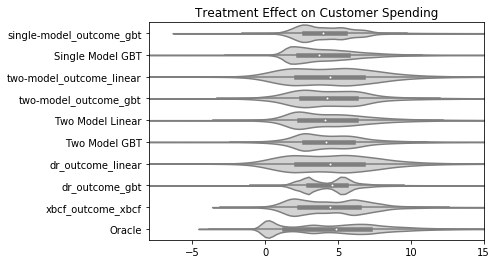

In [57]:
with PdfPages(f"../results/treatment_effect_on_spending.pdf") as pdf:
    sns.violinplot(data=effect_stage["treatment_spending"].clip(-10,20), scale='count', orient='h', color='lightgrey')
    plt.xlim(-8,15)
    plt.title("Treatment Effect on Customer Spending")
    pdf.savefig()

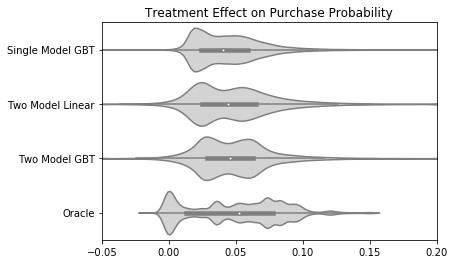

In [58]:
with PdfPages(f"../results/treatment_effect_on_conversion.pdf") as pdf:
    sns.violinplot(data=effect_stage["treatment_conversion"].clip(-0.05,0.2), scale='count', orient='h', color='lightgrey')
    plt.xlim(-0.05,0.2)
    plt.title("Treatment Effect on Purchase Probability")
    pdf.savefig()

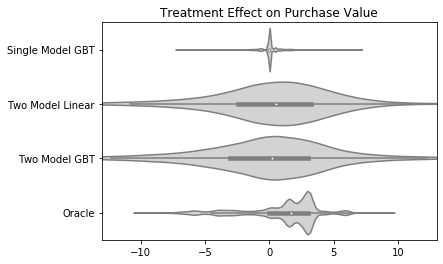

In [59]:
with PdfPages(f"../results/treatment_effect_on_value.pdf") as pdf:
    sns.violinplot(data=effect_stage["treatment_basket_value"].clip(-20,20), scale='count', orient='h', color='lightgrey')
    plt.xlim(-13,13)
    plt.title("Treatment Effect on Purchase Value")
    pdf.savefig()

In [60]:
effect_stage_summary.to_latex("../results/effect_summary_per_level.tex", na_rep="-", index=True)
effect_stage_summary

treatment_spending                             \
                                       mean      min   25%   50%   75%   
single-model_outcome_gbt               4.30    -5.94  2.67  3.96  5.50   
single-model_hurdle_gbt                4.34   -13.04  2.26  3.71  5.66   
two-model_outcome_linear               4.58 -1554.77  2.12  4.46  6.68   
two-model_outcome_gbt                  4.58   -17.60  2.44  4.27  6.26   
two-model_hurdle_linear                4.64  -311.49  2.32  4.07  6.27   
two-model_hurdle_gbt                   4.58   -26.21  2.63  4.15  6.02   
dr_outcome_linear                      4.58 -1527.97  2.10  4.46  6.69   
dr_outcome_gbt                         4.60  -381.34  2.91  4.57  5.56   
xbcf_outcome_xbcf                      4.64    -3.13  2.34  4.44  6.46   
oracle__                               4.80    -3.90  1.30  4.83  7.21   

                                 treatment_basket_value                       \
                             max                   mean      min   25%   50%   
single-model_outcome_gbt   35.98                    NaN      NaN   NaN   NaN   
single-model_hurdle_gbt    39.16                   0.08    -7.14  0.00  0.00   
two-model_outcome_linear  174.87                    NaN      NaN   NaN   NaN   
two-model_outcome_gbt      40.26                    NaN      NaN   NaN   NaN   
two-model_hurdle_linear   575.21                  -0.13 -2211.32 -2.40  0.55   
two-model_hurdle_gbt       56.36                  -0.23   -44.66 -3.09  0.19   
dr_outcome_linear         180.19                    NaN      NaN   NaN   NaN   
dr_outcome_gbt            327.05                    NaN      NaN   NaN   NaN   
xbcf_outcome_xbcf          22.66                    NaN      NaN   NaN   NaN   
oracle__                  117.53                   1.00   -10.00 -0.02  1.72   

                                      treatment_conversion                    \
                           75%    max                 mean   min   25%   50%   
single-model_outcome_gbt   NaN    NaN                  NaN   NaN   NaN   NaN   
single-model_hurdle_gbt   0.00   7.05                 0.04 -0.08  0.02  0.04   
two-model_outcome_linear   NaN    NaN                  NaN   NaN   NaN   NaN   
two-model_outcome_gbt      NaN    NaN                  NaN   NaN   NaN   NaN   
two-model_hurdle_linear   3.20  44.85                 0.05 -1.00  0.02  0.04   
two-model_hurdle_gbt      3.03  47.29                 0.05 -0.15  0.03  0.05   
dr_outcome_linear          NaN    NaN                  NaN   NaN   NaN   NaN   
dr_outcome_gbt             NaN    NaN                  NaN   NaN   NaN   NaN   
xbcf_outcome_xbcf          NaN    NaN                  NaN   NaN   NaN   NaN   
oracle__                  2.98   9.14                 0.05 -0.02  0.01  0.05   

                                      
                           75%   max  
single-model_outcome_gbt   NaN   NaN  
single-model_hurdle_gbt   0.06  0.26  
two-model_outcome_linear   NaN   NaN  
two-model_outcome_gbt      NaN   NaN  
two-model_hurdle_linear   0.07  0.94  
two-model_hurdle_gbt      0.06  0.38  
dr_outcome_linear          NaN   NaN  
dr_outcome_gbt             NaN   NaN  
xbcf_outcome_xbcf          NaN   NaN  
oracle__                  0.08  0.15

In [61]:
results = {}

for treatment_level in ["treatment_basket_value","treatment_conversion"]:  
    predictions_combined = pd.concat([pd.DataFrame(fold[treatment_level]) for fold in predictions_test])
    results[treatment_level] = {}
    for model in predictions_combined.columns.values:
        results[treatment_level][model] = np.sqrt(mean_absolute_error(y_pred=predictions_combined[[model]], 
                                                                     y_true=predictions_combined[["oracle__"]]))

In [62]:
results = pd.DataFrame(results)
results.index = pd.MultiIndex.from_tuples(results.index.str.split("[+|_]", expand=True).tolist())
results.columns = ["RMSE Basket Value", "RMSE Conversion"]
results.index.names = ["Causal","Stages","Estimator"]

results.drop('oracle', level="Causal", inplace=True)
results.reset_index(drop=False, inplace=True)

In [63]:
results

,Causal,Stages,Estimator,RMSE Basket Value,RMSE Conversion
0,single-model,hurdle,gbt,1.586720,0.151528
1,two-model,hurdle,linear,1.990707,0.158453
2,two-model,hurdle,gbt,2.094563,0.155283
3,ATE,,,1.829925,0.175813


In [64]:
results.to_latex("../results/stepwise_performance_hurdle_models.tex", na_rep="-", index=False, formatters={'RMSE Basket Value':'{:.2f}'.format,"RMSE Conversion":'{:.4f}'.format})

In [65]:
treatment_level= "treatment_basket_value"
predictions_combined = pd.concat([pd.DataFrame(fold[treatment_level]) for fold in predictions_test])

In [66]:
predictions_combined[['two-model_hurdle_linear']].mean()

two-model_hurdle_linear   -0.133867
dtype: float64

In [67]:
predictions_combined[['two-model_hurdle_linear']].quantile()

two-model_hurdle_linear    0.54638
Name: 0.5, dtype: float64

In [68]:
predictions_combined[['two-model_hurdle_gbt']].mean()

two-model_hurdle_gbt   -0.232688
dtype: float64

In [69]:
predictions_combined[['oracle__']].mean()

oracle__    1.000135
dtype: float64

In [70]:
predictions_combined[['oracle__']].quantile(q=[0,0.05,0.5,0.95,1])

,oracle__
0.00,-10.000000
0.05,-5.574609
0.50,1.717308
0.95,4.425391
1.00,9.142449
